In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('Business_Financials_Data.csv')

## Step 1 - Preview the first few rows

In [8]:
# Show the first few rows and all column names for a quick schema check
print(df.head())
print("Columns:", df.columns.tolist())

   Business ID Business State  Total Long-term Debt  Total Equity  \
0     41872013       Kentucky              16889000      18046000   
1     76232013           Iowa               6252000      18293621   
2    160992013          Texas              19200000     177858000   
3    197452013       Delaware             117592000     278773000   
4    241042013       Illinois               4408000      52064000   

   Debt to Equity  Total Liabilities  Total Revenue  Profit Margin  
0        0.935886           25986000      136753000       0.023663  
1        0.341758           14474000       34226553       0.265015  
2        0.107951           72787000      384196000       0.130413  
3        0.421820          558749000      444306000       0.196768  
4        0.084665           19898000      121541000       0.168305  
Columns: ['Business ID', 'Business State', 'Total Long-term Debt', 'Total Equity', 'Debt to Equity', 'Total Liabilities', 'Total Revenue', 'Profit Margin']


## Step 2 - Check columns

In [9]:
# Define the required schema for this analysis
required_col = ["Business ID",
                "Business State", 
                "Total Long-term Debt",
                "Total Equity",
                "Debt to Equity", 
                "Total Liabilities", 
                "Total Revenue", 
                "Profit Margin"]

# Identify missing columns
for col in required_col:
    if col not in df.columns:
        print(col, "is missing!")

## Step 3 - ID Missing Values

In [10]:
# Count and print the number of rows remaining after cleaning. Drop rows with missing values across all required fields
df_clean = df.dropna()
print(f"Rows after cleaning: {len(df_clean)}")

Rows after cleaning: 150


## Step 4 - Check for Duplicate Rows

Detect duplicates. If they exist, display them for review.  
The script will stop for review of duplicates before continuing.

In [11]:
# Identify duplicate rows in the cleaned dataset
dups = df_clean[df_clean.duplicated()]

if not dups.empty: 
    print("The following rows in the dataset could be duplicates. Please check the rows below:")
    print(dups)
    print("Remove duplicates manually if appropriate.")
    
    # Stop the script so the analyst can review 
    raise SystemExit("Execution stopped for review of duplicate rows.")
else: 
    print("No duplicate rows found.")

No duplicate rows found.


## Step 5a - Calculate Debt-to-Income Ratio

Calculate Debt to Income Ratio for each business and calculate the Debt-to-Income ratio using a formula (DTI = Total Long-term Debt ÷ Total Revenue)
This metric helps assess a company's leverage relative to its income. A higher DTI may indicate greater financial riks.


In [12]:
# Step 5a - Safeguard for division by 0
dti_val =[] 

for _, row in df_clean.iterrows():
    if row["Total Revenue"] == 0:
        dti_val.append(0) 
    else: dti_val.append(row["Total Long-term Debt"] / row["Total Revenue"]) 

# Step 5b - Create new dataframe for Debt-to-Income ratios
dti_df = pd.DataFrame()
dti_df["Business ID"] = df_clean["Business ID"]
dti_df["DebtToIncome"] = dti_val

print(dti_df.head())

   Business ID  DebtToIncome
0     41872013      0.123500
1     76232013      0.182665
2    160992013      0.049974
3    197452013      0.264664
4    241042013      0.036268


## Step 5b - Merge Debt-to-Income Back into original data

Concatenation creates a combined dataframe (`df_combined`) that includes all original fields plus the DTI column.

In [13]:
# Concatenate the new DTI dataframe back to the cleaned data
df_combined = pd.concat([df_clean, dti_df["DebtToIncome"]], axis=1)

# Preview data
print("Business-level dataframe with Debt-to-Income added:")
print(df_combined[["Business ID", "Business State", "DebtToIncome"]].head())

# Show first few rows of the whole dataset
print("Debt-to-Income column added (via separate dataframe + concat):")
print(df_combined.head())

Business-level dataframe with Debt-to-Income added:
   Business ID Business State  DebtToIncome
0     41872013       Kentucky      0.123500
1     76232013           Iowa      0.182665
2    160992013          Texas      0.049974
3    197452013       Delaware      0.264664
4    241042013       Illinois      0.036268
Debt-to-Income column added (via separate dataframe + concat):
   Business ID Business State  Total Long-term Debt  Total Equity  \
0     41872013       Kentucky              16889000      18046000   
1     76232013           Iowa               6252000      18293621   
2    160992013          Texas              19200000     177858000   
3    197452013       Delaware             117592000     278773000   
4    241042013       Illinois               4408000      52064000   

   Debt to Equity  Total Liabilities  Total Revenue  Profit Margin  \
0        0.935886           25986000      136753000       0.023663   
1        0.341758           14474000       34226553       0.265015

## Step 6 - Identify Businesses with Negative Debt-to-Equity

A negative Debt-to-Equity ratio usually means that liabilities exceed assets, or the business has accumulated losses that exceed equity.

In [14]:
# Filter rows with negative Debt-to_Equity

# Create a subset where Debt-to-Equity < 0
neg_dte = df_combined[df_combined["Debt to Equity"] < 0]
print("Businesses with NEGATIVE Debt-to-Equity ratios:")

# Display the results
print(neg_dte)

Businesses with NEGATIVE Debt-to-Equity ratios:
     Business ID Business State  Total Long-term Debt  Total Equity  \
18     934562013           Ohio             263880000    -111297000   
57    8343652013     Washington              10603000     -13271658   
87    9323722013     California              21560000     -15691000   
109  10919832013           Utah               2010000      -3602481   
117  11245242013     California                556000      -2063203   
142  14535932013        Montana              16459000      -3842372   
143  14639722013       New York                187000     -13037879   

     Debt to Equity  Total Liabilities  Total Revenue  Profit Margin  \
18        -2.370953          592174000      719783000       0.320697   
57        -0.798921           16625000        8949401       0.448119   
87        -1.374036           30048000       37782000       0.505955   
109       -0.557949            6302000       17757388       0.732562   
117       -0.269484    

## Step 7 - State-Level Descriptive Statistics

**Purpose:**

To understand the data geographically, group the data by State and calculate descriptive statistics for each column.

**Output:**

Descriptive Statistics help identify states with higher average leverage, profitability ranges, 
and overall variability in financial healh. 


In [15]:
# Group by State and calculate descriptive statistics 

# Define summary metrics
metrics_cols = ["Total Long-term Debt",
                "Total Equity",
                "Total Liabilities",
                "Total Revenue",
                "Profit Margin",
                "DebtToIncome"]
                    
# Group by State and calculate descriptive statistics: mean, median, min, and max for each metric per State
agg_results = df_combined.groupby("Business State")[metrics_cols].agg(['mean','median','min','max'])

# Print preview of aggregate results
print("State-level descriptive statistics:")
print(agg_results.head())

State-level descriptive statistics:
               Total Long-term Debt                                     \
                               mean       median       min         max   
Business State                                                           
Alabama                6.743890e+08  674389000.0   5314000  1343464000   
Arizona                6.508800e+07   65088000.0  65088000    65088000   
Arkansas               8.960450e+07   89604500.0  70366000   108843000   
California             3.273964e+07    4721500.0     15000   334997000   
Colorado               8.470025e+07   29327000.0   3375000   375322000   

                Total Equity                                       \
                        mean        median        min         max   
Business State                                                      
Alabama         1.441039e+09  1.441039e+09   24058479  2858019000   
Arizona         5.915300e+07  5.915300e+07   59153000    59153000   
Arkansas        1.082420e+

## Step 8 - Export Results to CSV

Save cleaned and enriched datasets to CSV files for further analysis and reporting:

1. Businesses with Negative Debt-to-Equity - `negative_debt_to_equity_businesses.csv`  
2. Business-level data - `business_level_with_DTI.csv`  
3. State-level descriptive statistics - `state_descriptive_stats.csv`  

In [16]:
# Save all 3 files to CSV

# 1. Businesses with negative Debt-to-Equity
neg_dte.to_csv("negative_debt_to_equity_businesses.csv", index=False)

# 2. Business-level dataframe with Debt-to-Income
df_combined.to_csv("business_level_with_DTI.csv", index=False)

# 3. State-level descriptive statistics
agg_results.to_csv("state_descriptive_stats.csv")

print("Analysis complete.")

Analysis complete.


## Step 9 - Visualizations

In this step, I visualize leverage vs profitability and surface state-level leverage patterns.
Each plot has a short interpretation directly below it


### 9a - Setup for Visualizations

In [17]:
# Imports for plotting in Step 9
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [18]:
# Make a copy with easy-to-type column names
dfp = df_combined.rename(columns={
    'Business ID': 'Business_ID',
    'Business State': 'Business_State',
    'Profit Margin': 'Profit_Margin',
    'Debt to Equity': 'Debt_to_Equity',
    'DebtToIncome': 'Debt_to_Income'
})

# Drop any Nans
plot_df = dfp[['Business_ID', 'Business_State',
               'Debt_to_Income', 'Profit_Margin', 'Debt_to_Equity']].dropna()

### 9b - Scatterplot of Profit Margin vs Debt-to-Income
This chart examines whether profitability is related to Debt to Income (DTI) ratio.



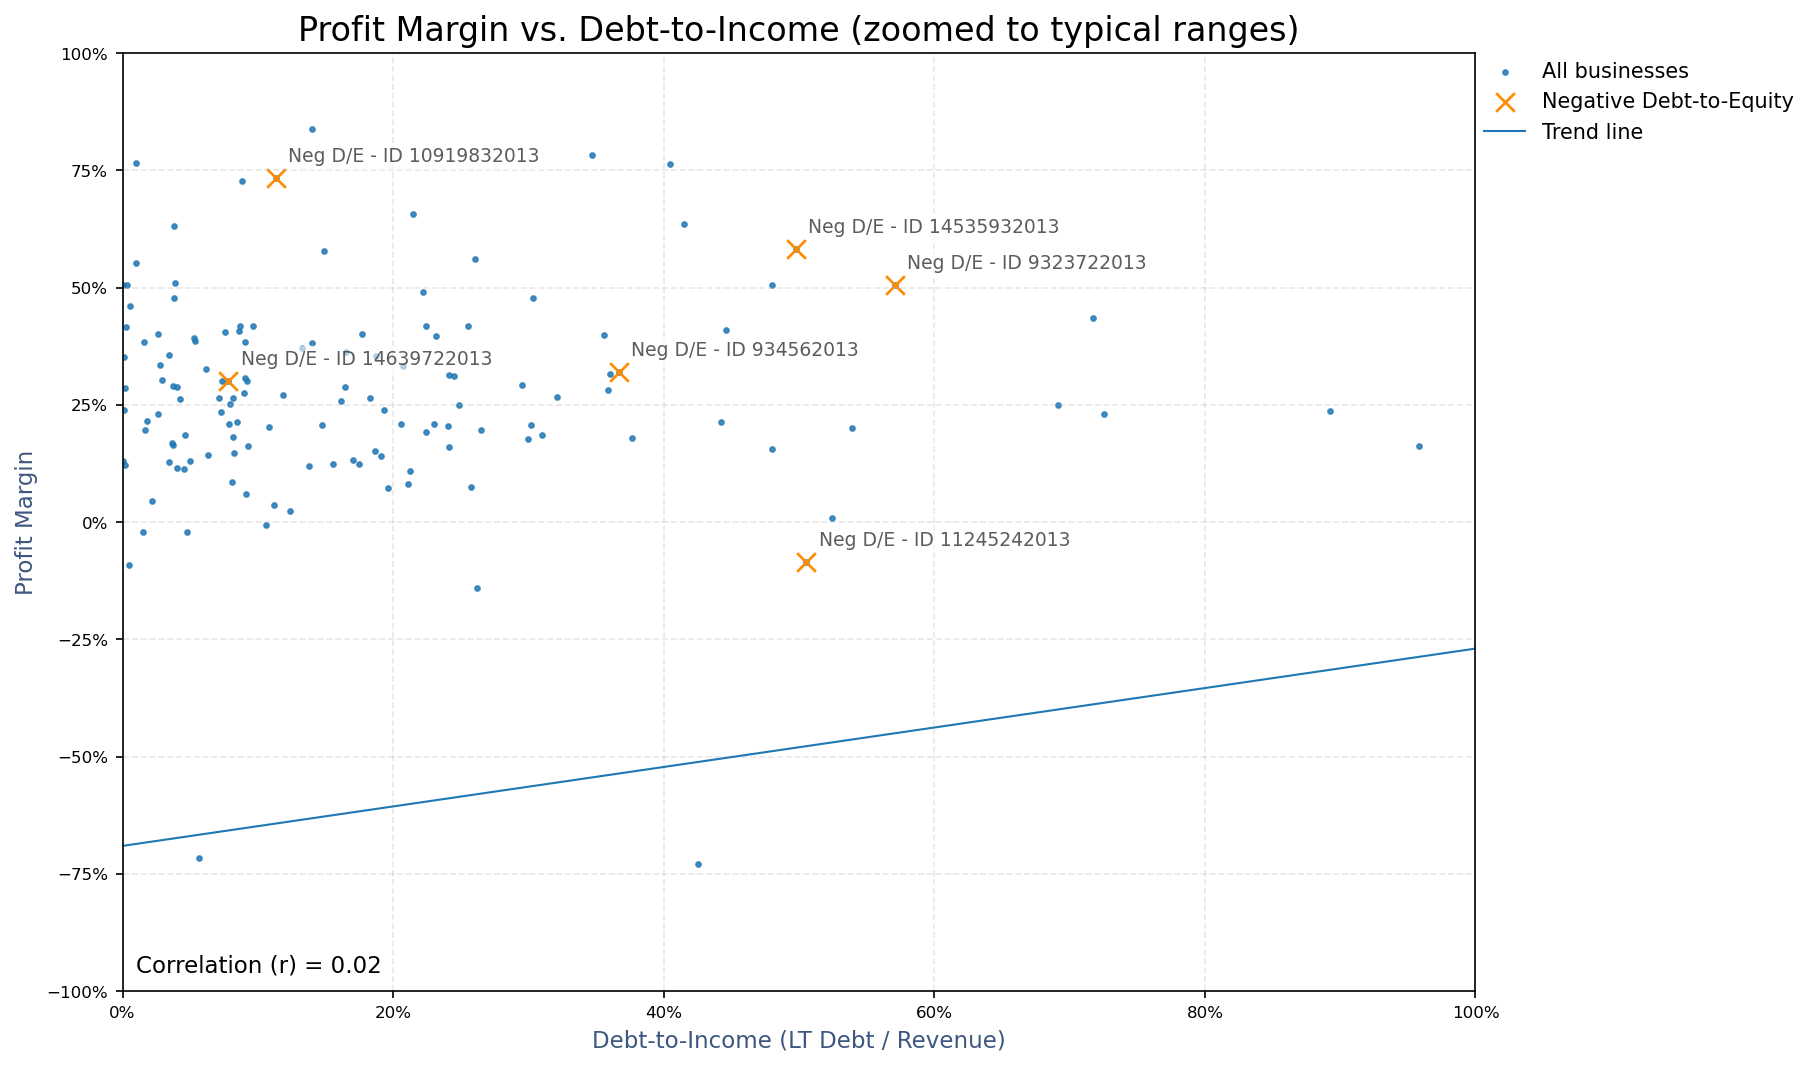

In [19]:
import numpy as np
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 7), dpi=150, constrained_layout=True)

# Define the sizes of scatterplot points 
ax.scatter(
    plot_df['Debt_to_Income'], plot_df['Profit_Margin'],
    s=5, alpha=0.80, label='All businesses'
)

# Mark companies with negative Debt-to-Equity using "x"
neg_mask = plot_df['Debt_to_Equity'] < 0
if neg_mask.any():
    ax.scatter(
        plot_df.loc[neg_mask, 'Debt_to_Income'],
        plot_df.loc[neg_mask, 'Profit_Margin'],
        marker='x', s=80, linewidths= 1.3,
        color='darkorange',
        label='Negative Debt-to-Equity'
    )

# Show DTI 0–100% and Profit Margin –100%–100%
# label ticks as percentages
ax.set_xlim(0, 1)     # DTI: 0–100%
ax.set_ylim(-1, 1)    # Profit Margin: -100%–100%
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.tick_params(axis='both', labelsize=8)

# Correlation
corr = plot_df['Debt_to_Income'].corr(plot_df['Profit_Margin'])
ax.text(0.01, 0.02, f"Correlation (r) = {corr:.2f}",
        transform=ax.transAxes, fontsize=11)

# Trend line
xy = plot_df[['Debt_to_Income','Profit_Margin']].dropna().to_numpy()
if len(xy) > 1:
    x, y = xy[:,0], xy[:,1]
    m, b = np.polyfit(x, y, 1)
    xg = np.linspace(*ax.get_xlim(), 100)
    ax.plot(xg, m*xg + b, linewidth=1, label='Trend line')

# Annotate negative Debt-to-Equity companies
if neg_mask.any():
    neg_df = plot_df[neg_mask].sort_values(['Debt_to_Income','Profit_Margin']).reset_index(drop=True)
    offsets = [(8, 8), (-8, 8), (8, -8), (-8, -8), (12, 0), (-12, 0)]
    for i, row in neg_df.iterrows():
        dx, dy = offsets[i % len(offsets)]
        ax.annotate(
    f"Neg D/E - ID {row['Business_ID']}",
    (row['Debt_to_Income'], row['Profit_Margin']),
    xytext=(6, 6), textcoords='offset points',   
    ha='left', va='bottom',                     
    fontsize=9, color='0.2', alpha=0.8,
    bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.6)
)

# Add plot labels
ax.set_xlabel('Debt-to-Income (LT Debt / Revenue)', fontsize=11, color='#3E5780')
ax.set_ylabel('Profit Margin', fontsize=11, color='#3E5780')
ax.set_title('Profit Margin vs. Debt-to-Income (zoomed to typical ranges)', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.3)

# Place the legend outside so it doesn't cover points
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., frameon=False)

plt.show()

Below is a supporting table showing businesses with negative Debt to Equity.

In [20]:
# Filter rows with negative Debt-to-Equity
neg = dfp.loc[dfp['Debt_to_Equity'] < 0,
              ['Business_ID', 'Business_State', 'Debt_to_Income', 'Profit_Margin']].copy()

# Display percentages
neg_styled = (
    neg.style
       .format({'Debt_to_Income': '{:.1%}', 'Profit_Margin': '{:.1%}'})
       .set_caption("Businesses with Negative Debt-to-Equity")
       .set_table_styles([{
           'selector': 'caption',
           'props': [('font-size', '12pt'), ('text-align', 'left'),
                     ('font-weight', 'bold'), ('color', '#333')]
       }])
)

neg_styled

,Business_ID,Business_State,Debt_to_Income,Profit_Margin
18,934562013,Ohio,36.7%,32.1%
57,8343652013,Washington,118.5%,44.8%
87,9323722013,California,57.1%,50.6%
109,10919832013,Utah,11.3%,73.3%
117,11245242013,California,50.5%,-8.5%
142,14535932013,Montana,49.8%,58.2%
143,14639722013,New York,7.8%,30.1%


### 9c - Bar Chart - Average Debt-to-Income by State
This chart shows which states have higher average leverage levels.

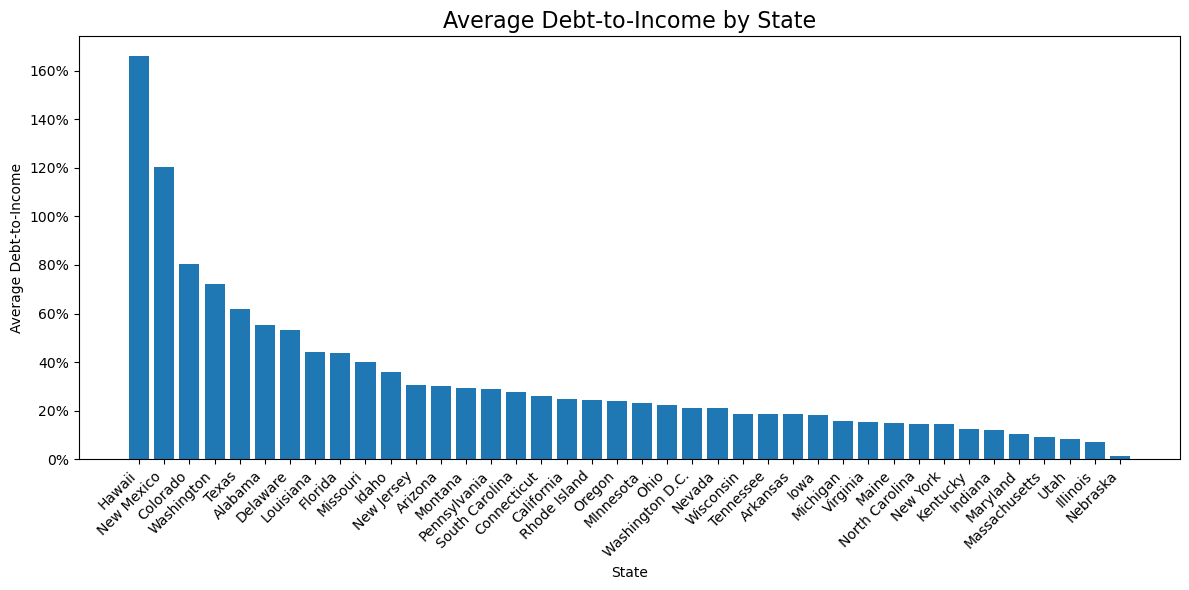

Top 5 states by Avg DTI:
  Business_State   Avg_DTI
0         Hawaii  1.657996
1     New Mexico  1.203539
2       Colorado  0.804851
3     Washington  0.723478
4          Texas  0.617214

Bottom 5 states by Avg DTI:
   Business_State   Avg_DTI
35       Maryland  0.104514
36  Massachusetts  0.091191
37           Utah  0.083036
38       Illinois  0.071753
39       Nebraska  0.015622


In [25]:
# Bar chart — Average Debt-to-Income (DTI) by State

# Compute mean DTI per state and sort in a descending order
avg_dti_by_state = (
    dfp.groupby('Business_State', dropna=False)['Debt_to_Income']
       .mean()
       .sort_values(ascending=False)
       .reset_index()
       .rename(columns={'Debt_to_Income': 'Avg_DTI'})
)

plt.figure(figsize=(12, 6))
plt.bar(avg_dti_by_state['Business_State'], avg_dti_by_state['Avg_DTI'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Debt-to-Income')
plt.xlabel('State')
plt.title('Average Debt-to-Income by State', fontsize=16)

# Format y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

plt.tight_layout()
plt.show()

# Print  5 top and bottom states
print("Top 5 states by Avg DTI:")
print(avg_dti_by_state.head(5))
print("\nBottom 5 states by Avg DTI:")
print(avg_dti_by_state.tail(5))

### 9d - Risk-Colored Scatterplot and Risk Tiers for Risk Management Policy

**Purpose:**

Turn the Profit Margin vs DTI view into an actionable risk view

**Method:**
- Use medians to create risk quadrants
- Flag very high DTI using an IQR upper fence
- Define risk tiers

**Risk Tiers:**
- High - negative equity, negative margin, very high DTI, or in High-DTI / Low-PM quadrant
- Low - if Low-DTI / High-PM and no red flags.
- Medium - otherwise

**Outputs:**

A risk-colored scatter, CSVs by tier, and a short “Actionable Insights” summary

Median DTI = 0.1483  |  Median Profit Margin = 0.2687


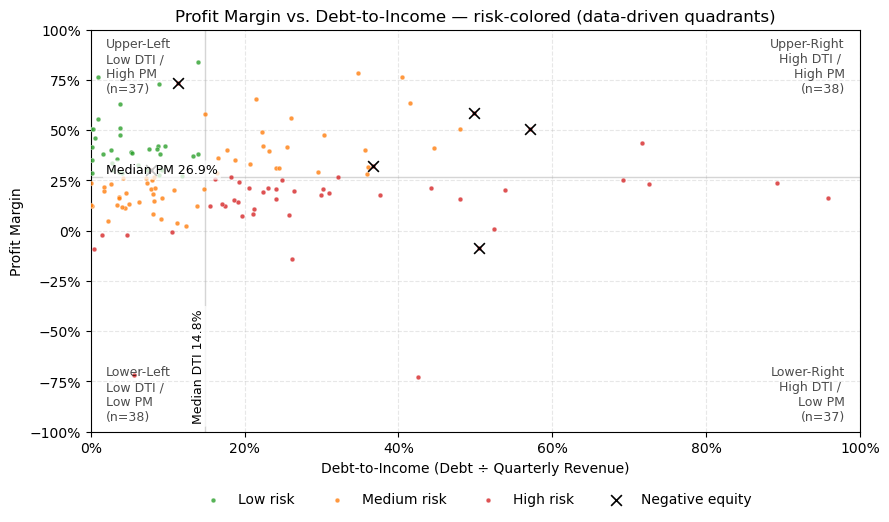


=== HIGH RISK — 59 companies ===
 Business_ID  Business_State  DTI_%      PM_%  Debt_to_Equity
    76232013            Iowa  18.3%     26.5%        0.341758
   197452013        Delaware  26.5%     19.7%        0.421820
   497282013        New York  24.1%     15.9%        1.063512
   919282013      New Jersey  95.8%     16.3%        0.847710
   934562013            Ohio  36.7%     32.1%       -2.370953
   959532013        Virginia  10.6%     -0.7%        0.197025
   968852013      New Jersey  18.7%     15.2%        0.541827
  1027522013        Virginia  19.1%     14.2%        0.482904
  1048972013       MInnesota  29.9%     17.8%        0.837806
  1056082013        Illinois   5.7%    -71.7%        0.096457
  2775952013         Alabama 106.9%     29.7%        0.470068
  3158522013           Texas 171.4%     68.9%        1.300716
  3504032013       Louisiana  44.2%     21.3%        0.676828
  3518172013           Texas 195.5%     64.0%        1.072294
  7017192013           Texas   4.8% 

In [21]:
# Scatterplot with risk levels (high-risk:red, medium-risk: orange, low-risk:green) 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.transforms import blended_transform_factory

# Build a clean plotting DataFrame
dfp = df_combined.rename(columns={
    'Business ID'    : 'Business_ID',
    'Business State' : 'Business_State',
    'Profit Margin'  : 'Profit_Margin',
    'Debt to Equity' : 'Debt_to_Equity',
    'DebtToIncome'   : 'Debt_to_Income',
})
plot_df = dfp[['Business_ID','Business_State','Debt_to_Income','Profit_Margin','Debt_to_Equity']].dropna()

# Data-driven cut lines (medians) 
x0 = plot_df['Debt_to_Income'].median()     # vertical cut (DTI)
y0 = plot_df['Profit_Margin'].median()      # horizontal cut (PM)
print(f"Median DTI = {x0:.4f}  |  Median Profit Margin = {y0:.4f}")

# Box-plot outlier fence for DTI (to flag very high leverage)
q1, q3 = plot_df['Debt_to_Income'].quantile([0.25, 0.75])
iqr = q3 - q1
dti_upper_fence = q3 + 1.5*iqr

# Risk flags
plot_df['neg_equity']    = plot_df['Debt_to_Equity'] < 0
plot_df['neg_margin']    = plot_df['Profit_Margin']  < 0
plot_df['very_high_DTI'] = plot_df['Debt_to_Income'] > dti_upper_fence

# Quadrants (for counts) 
left  = plot_df['Debt_to_Income'] <= x0
right = ~left
above = plot_df['Profit_Margin']  >= y0
below = ~above
UL = (left  & above)   # Low Debt to Income and High Profit Margin
UR = (right & above)   # High Debt to Income and High Profit Margin
LL = (left  & below)   # Low Debt to Income and Low Profit Margin
LR = (right & below)   # High Debt to Income and Low Profit Margin

# RISK TIERS DEFINITION

# HIGH RISK: Equity < 0 OR High DTI with Low Profit margin
high_cond = plot_df['neg_equity'] | plot_df['neg_margin'] | plot_df['very_high_DTI'] | LR
# LOW RISK: Low DTI & High margin (EQUITY NOT < 0)
low_cond  = UL & (~high_cond)
# MEDIUM RISK: everything else
plot_df['risk_tier'] = np.where(high_cond, 'High', np.where(low_cond, 'Low', 'Medium'))

# Create a scatterplot
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Lines for median guides
ax.axvline(x0, color='0.35', linewidth=1, alpha=0.25, zorder=0)
ax.axhline(y0, color='0.35', linewidth=1, alpha=0.25, zorder=0)

# Colors for risk tier points
palette = {'Low':'#2ca02c', 'Medium':'#ff7f0e', 'High':'#d62728'}  # green / orange / red

# Plot each tier
for tier in ['Low','Medium','High']:
    d = plot_df[plot_df['risk_tier'] == tier]
    ax.scatter(d['Debt_to_Income'], d['Profit_Margin'],
               s=12, alpha=0.80, edgecolors='white', linewidths=0.3,
               c=palette[tier], label=f'{tier} risk', zorder=3)

# Mark negative equity with a black "x"
if plot_df['neg_equity'].any():
    de = plot_df[plot_df['neg_equity']]
    ax.scatter(de['Debt_to_Income'], de['Profit_Margin'],
               marker='x', s=60, linewidths=1.2, c='k', label='Negative equity', zorder=4)

# Plot axes and labels
ax.set_xlim(0, 1); ax.set_ylim(-1, 1)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Debt-to-Income (Debt ÷ Quarterly Revenue)')
plt.ylabel('Profit Margin')
plt.title('Profit Margin vs. Debt-to-Income — risk-colored (data-driven quadrants)')
plt.grid(True, linestyle='--', alpha=0.3)

# Add a legend at the bottom of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, frameon=False)
plt.tight_layout(rect=[0, 0.10, 1, 1])

# ADD QUADRANT LABELS
ul_n = int(UL.sum()); ur_n = int(UR.sum()); ll_n = int(LL.sum()); lr_n = int(LR.sum())
# top-left (Upper-Left)
ax.text(0.02, 0.98, f"Upper-Left\nLow DTI / \nHigh PM\n(n={ul_n})",
        transform=ax.transAxes, ha='left', va='top', fontsize=9, alpha=0.7)
# top-right (Upper-Right)
ax.text(0.98, 0.98, f"Upper-Right\nHigh DTI / \nHigh PM\n(n={ur_n})",
        transform=ax.transAxes, ha='right', va='top', fontsize=9, alpha=0.7)
# bottom-left (Lower-Left)
ax.text(0.02, 0.02, f"Lower-Left\nLow DTI / \nLow PM\n(n={ll_n})",
        transform=ax.transAxes, ha='left', va='bottom', fontsize=9, alpha=0.7)
# bottom-right (Lower-Right)
ax.text(0.98, 0.02, f"Lower-Right\nHigh DTI / \nLow PM\n(n={lr_n})",
        transform=ax.transAxes, ha='right', va='bottom', fontsize=9, alpha=0.7)

# ADD LABELS FOR MEDIANS
box = dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.75)
transX = blended_transform_factory(ax.transData, ax.transAxes)
transY = blended_transform_factory(ax.transAxes, ax.transData)
ax.text(x0, 0.02, f"Median DTI {x0:.1%}", transform=transX, rotation=90,
        ha="right", va="bottom", fontsize=9, bbox=box, zorder=6)
ax.text(0.02, y0, f"Median PM {y0:.1%}", transform=transY,
        ha="left",  va="bottom", fontsize=9, bbox=box, zorder=6)

plt.show()

# Tables of Business_IDs by risk tier
def pct(s): return (s*100).round(1).astype(str) + '%'
report_cols = ['Business_ID','Business_State','Debt_to_Income','Profit_Margin','Debt_to_Equity','risk_tier']
out = plot_df[report_cols].copy()
out['Debt_to_Income'] = pct(out['Debt_to_Income'])
out['Profit_Margin']  = pct(out['Profit_Margin'])

for tier in ['High','Medium','Low']:
    block = (out[out['risk_tier']==tier]
             .rename(columns={'Debt_to_Income':'DTI_%','Profit_Margin':'PM_%'})
             [['Business_ID','Business_State','DTI_%','PM_%','Debt_to_Equity']])
    print(f"\n=== {tier.upper()} RISK — {len(block)} companies ===")
    print(block.to_string(index=False))
    # Save to CSV for stakeholders
    block.to_csv(f'{tier.lower()}_risk_companies.csv', index=False)

# Actionable insights
n_high = int((plot_df['risk_tier']=='High').sum())
n_med  = int((plot_df['risk_tier']=='Medium').sum())
n_low  = int((plot_df['risk_tier']=='Low').sum())
neg_eq = int(plot_df['neg_equity'].sum())
neg_pm = int(plot_df['neg_margin'].sum())
vh_dti = int(plot_df['very_high_DTI'].sum())
lr_ct  = int(LR.sum())
ul_ct  = int(UL.sum())
ur_ct  = int(UR.sum())
ll_ct  = int(LL.sum())

top_dti = (plot_df.sort_values('Debt_to_Income', ascending=False)
           .head(5)[['Business_ID','Debt_to_Income','Profit_Margin']])
top_dti['Debt_to_Income'] = pct(top_dti['Debt_to_Income'])
top_dti['Profit_Margin']  = pct(top_dti['Profit_Margin'])

print("\n--- ACTIONABLE INSIGHTS ---")
print(f"- Medians: DTI {x0:.1%}, Profit Margin {y0:.1%}. DTI outlier fence (Q3+1.5*IQR): {dti_upper_fence:.1%}.")
print(f"- Risk mix: {n_low} Low, {n_med} Medium, {n_high} High.")
print(f"- High-risk drivers: {neg_eq} negative-equity, {neg_pm} negative-margin, {vh_dti} DTI outliers; "
      f"{lr_ct} firms in High-DTI/Low-Margin quadrant.")
print(f"- Healthy core: {ul_ct} firms in Low-DTI/High-Margin quadrant; consider core holdings.")
print(f"- Leveraged performers: {ur_ct} firms (High-DTI/High-Margin); monitor refinancing-rate sensitivity.")
print(f"- Operational underperformers: {ll_ct} firms (Low-DTI/Low-Margin); focus on margin improvement plans.")
print("- Top 5 by DTI (for immediate review):")
print(top_dti.to_string(index=False))

### 9e - Very-High DTI Outliers (Table)

**Purpose:**

List companies whose Debt-to-Income exceeds the IQR upper fence (Q3 + 1.5×IQR)
Also surface the subset that sits in the **High-DTI / Low-Margin** quadrant (highest concern)

**Outputs:**

CSV files for stakeholders

In [22]:
# Which companies are "very high DTI" outliers?
# (defined earlier as Debt_to_Income > dti_upper_fence)

def pct(s): return (s*100).round(1).astype(str) + '%'

very_high = (plot_df[plot_df['very_high_DTI']]
             .sort_values('Debt_to_Income', ascending=False)
             .copy())

print(f"DTI outlier fence: {dti_upper_fence:.1%}  |  Companies flagged: {len(very_high)}")

tbl = very_high.assign(
        DTI_pct=pct(very_high['Debt_to_Income']),
        PM_pct =pct(very_high['Profit_Margin'])
     )[["Business_ID","Business_State","DTI_pct","PM_pct","Debt_to_Equity"]]

print("\n=== VERY HIGH DTI COMPANIES ===")
print(tbl.to_string(index=False))

# Save for stakeholders
tbl.to_csv("very_high_dti_companies.csv", index=False)

# Subset that are both very-high DTI AND in High-DTI/Low-Margin quadrant
vh_lr = very_high[ (very_high['Debt_to_Income'] > x0) & (very_high['Profit_Margin'] < y0) ]
if len(vh_lr):
    tbl_lr = vh_lr.assign(DTI_pct=pct(vh_lr['Debt_to_Income']),
                          PM_pct =pct(vh_lr['Profit_Margin']))[
                          ["Business_ID","Business_State","DTI_pct","PM_pct","Debt_to_Equity"]]
    print("\n--- Highest concern (Very-High DTI AND High-DTI/Low-Margin quadrant) ---")
    print(tbl_lr.to_string(index=False))
    tbl_lr.to_csv("very_high_dti_highrisk_quadrant.csv", index=False)

DTI outlier fence: 67.6%  |  Companies flagged: 17

=== VERY HIGH DTI COMPANIES ===
 Business_ID Business_State DTI_pct  PM_pct  Debt_to_Equity
 13752052013       Colorado  446.4%   53.3%        0.879371
 12826482013          Texas  318.5%  -39.4%        2.199365
  3518172013          Texas  195.5%   64.0%        1.072294
  3158522013          Texas  171.4%   68.9%        1.300716
 15456542013         Hawaii  165.8%   34.9%        0.516110
  8440592013        Florida  164.9% -285.1%        0.236667
  8631102013       Delaware  152.8%   41.0%        0.866000
  7668292013     California  121.0%   31.1%        1.043036
 11084262013     New Mexico  120.4%   32.7%        0.947957
  8343652013     Washington  118.5%   44.8%       -0.798921
 10162812013          Texas  110.8%   32.6%        1.513711
  2775952013        Alabama  106.9%   29.7%        0.470068
   919282013     New Jersey   95.8%   16.3%        0.847710
 12942502013     New Jersey   89.2%   23.7%        1.929907
 13424232013    

### 9e.1 - Table of High DTI Companies

HTML table showing high Debt to Income companies    

In [23]:
tbl_style = (very_high[['Business_ID','Business_State','Debt_to_Income','Profit_Margin','Debt_to_Equity']]
             .rename(columns={'Debt_to_Income':'DTI','Profit_Margin':'PM'})
             .style.format({'DTI':'{:.1%}','PM':'{:.1%}'})
             .set_caption("Very-High DTI Companies"))
tbl_style

,Business_ID,Business_State,DTI,PM,Debt_to_Equity
134,13752052013,Colorado,446.4%,53.3%,0.879371
123,12826482013,Texas,318.5%,-39.4%,2.199365
33,3518172013,Texas,195.5%,64.0%,1.072294
29,3158522013,Texas,171.4%,68.9%,1.300716
148,15456542013,Hawaii,165.8%,34.9%,0.516110
60,8440592013,Florida,164.9%,-285.1%,0.236667
63,8631102013,Delaware,152.8%,41.0%,0.866000
47,7668292013,California,121.0%,31.1%,1.043036
114,11084262013,New Mexico,120.4%,32.7%,0.947957
57,8343652013,Washington,118.5%,44.8%,-0.798921


### 9f - Companies with Debt-to-Income Above 50%

**Purpose:**  
Identify businesses where Equity < 0 (for immediate review) and Debt-to-Income exceeds 50%.

**Method:**  
- Filter companies where Debt-to-Income exceeds 50%.  
- Mark an **X** on bars for companies with negative equity.  
- Add a Debt-to-Income outlier line at 50% (IQR upper fence = Q3 + 1.5 × IQR).  

**Outputs:**  
- Horizontal bar chart  
- Supporting data table used for the chart  

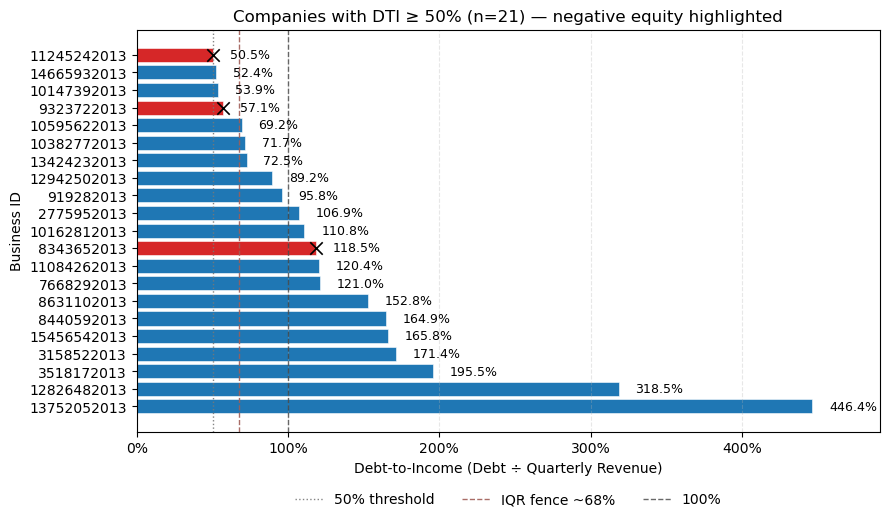

 Business_ID Business_State  DTI_%  Debt_to_Equity
 13752052013       Colorado  446.4        0.879371
 12826482013          Texas  318.5        2.199365
  3518172013          Texas  195.5        1.072294
  3158522013          Texas  171.4        1.300716
 15456542013         Hawaii  165.8        0.516110
  8440592013        Florida  164.9        0.236667
  8631102013       Delaware  152.8        0.866000
  7668292013     California  121.0        1.043036
 11084262013     New Mexico  120.4        0.947957
  8343652013     Washington  118.5       -0.798921
 10162812013          Texas  110.8        1.513711
  2775952013        Alabama  106.9        0.470068
   919282013     New Jersey   95.8        0.847710
 12942502013     New Jersey   89.2        1.929907
 13424232013     California   72.5        0.556361
 10382772013          Idaho   71.7        1.013410
 10595622013       Missouri   69.2        1.979749
  9323722013     California   57.1       -1.374036
 10147392013       Colorado   5

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as mpatches

# Rebuild a clean plotting frame from df_combined
if 'plot_df' not in globals():
    dfp = df_combined.rename(columns={
        'Business ID'    : 'Business_ID',
        'Business State' : 'Business_State',
        'Profit Margin'  : 'Profit_Margin',
        'Debt to Equity' : 'Debt_to_Equity',
        'DebtToIncome'   : 'Debt_to_Income',
    })
    plot_df = dfp[['Business_ID','Business_State','Debt_to_Income',
                   'Profit_Margin','Debt_to_Equity']].dropna()

# Thresholds
THR_50 = 0.50  # business rule: "very high" DTI is 50%+
q1, q3 = plot_df['Debt_to_Income'].quantile([0.25, 0.75])
IQR_FENCE = float(q3 + 1.5*(q3 - q1))  # ≈ 0.68 for this dataset
EXTREME = 1.00  # 100%

# Filter & sort 
d = (plot_df[plot_df['Debt_to_Income'] >= THR_50]
     [['Business_ID','Business_State','Debt_to_Income','Debt_to_Equity']]
     .sort_values('Debt_to_Income', ascending=False)
     .reset_index(drop=True))

neg_eq = d['Debt_to_Equity'] < 0
colors = np.where(neg_eq, '#d62728', '#1f77b4')  # red if negative equity else blue

# Scatterplot
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Bar styling
ax.barh(d['Business_ID'].astype(str), d['Debt_to_Income'],
        color=colors, edgecolor='white', linewidth=0.4)

# Mark negative equity with a black X
ypos = np.arange(len(d))
ax.scatter(d.loc[neg_eq, 'Debt_to_Income'], ypos[neg_eq],
           marker='x', s=80, c='k', linewidths=1.2, zorder=3)

# Add a vertical line at 50% Debt to Income 
ax.axvline(THR_50, color='#777', linestyle=':',  linewidth=1, alpha=0.9, label='50% threshold')
ax.axvline(min(IQR_FENCE, d['Debt_to_Income'].max()*1.05),
           color='#a05d56', linestyle='--', linewidth=1, alpha=0.9,
           label=f'IQR fence ~{IQR_FENCE:.0%}')
ax.axvline(min(EXTREME, d['Debt_to_Income'].max()*1.05),
           color='#444', linestyle='--', linewidth=1, alpha=0.8, label='100%')

# Axes, grid, titles
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel('Debt-to-Income (Debt ÷ Quarterly Revenue)')
ax.set_ylabel('Business ID')
ax.set_title(f'Companies with DTI ≥ 50% (n={len(d)}) — negative equity highlighted')
ax.grid(axis='x', linestyle='--', alpha=0.3)

# Push labels to the right & add right padding
xmax = float(d['Debt_to_Income'].max())
right_pad = 0.10 * xmax    # 10% extra right space
xshift    = 0.025 * xmax   # shift for text beyond bar end
ax.set_xlim(0, xmax + right_pad)

for i, val in enumerate(d['Debt_to_Income'].to_numpy()):
    ax.text(val + xshift, i, f'{val:.1%}',
            va='center', ha='left', fontsize=9, clip_on=False)

# Add a legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, frameon=False)
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.show()

# Print table used for the chart
tbl = d.copy()
tbl['DTI_%'] = (tbl['Debt_to_Income'] * 100).round(1)
print(
    tbl[['Business_ID','Business_State','DTI_%','Debt_to_Equity']]
      .to_string(index=False)
)

### 9g - RETURN ON EQUITY (DuPont Analysis Visualization)

**Purpose:**

Calculate Return on Equity, Return on Assets, and DuPont drivers for the analysis of financial strength of each company

**Assumptions:**

This analysis uses df_combined from the previous steps
Outputs:
- 9g.1 - Return on Equity vs. Debt to Equity Chart
- 9g.2 - Profit Margin vs. Asset Turnover Chart

### 9g.1 - DuPont Analysis Chart 1 - Return on Equity vs. Debt to Equity Chart

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

Make a working copy of the data

In [8]:
dpdf = df_combined.copy()

NameError: name 'df_combined' is not defined

Create Columns: 

- Total Assets (Total Liabilities + Total Equity) 

- Net Income (Profit Margin * Total Revenue)

In [9]:
dpdf['Total Assets'] = dpdf['Total Liabilities'] + dpdf['Total Equity']
dpdf['Net Income'] = dpdf['Profit Margin'] * dpdf['Total Revenue']

NameError: name 'dpdf' is not defined

DuPont Drivers Calculations

Asset Turnover = Revenue ÷ Assets
Equity Multiplier = Assets ÷ Equity
ROE = Net Income ÷ Equity
ROA = Net Income ÷ Assets

In [320]:
dpdf['Asset_Turnover'] = dpdf['Total Revenue'] / dpdf['Total Assets']
dpdf['Equity_Mult'] = dpdf['Total Assets'] / dpdf['Total Equity']
dpdf['ROE'] = dpdf['Net Income'] / dpdf['Total Equity']
dpdf['ROA'] = dpdf['Net Income'] / dpdf['Total Assets']

Preview columns

In [321]:
cols = ['Business ID','Business State','Total Assets','Net Income',
        'Asset_Turnover','Equity_Mult','ROE','ROA']
print(dpdf[cols].head())

   Business ID Business State  Total Assets    Net Income  Asset_Turnover  \
0     41872013       Kentucky      44032000  3.236000e+06        3.105764   
1     76232013           Iowa      32767621  9.070553e+06        1.044524   
2    160992013          Texas     250645000  5.010400e+07        1.532829   
3    197452013       Delaware     837522000  8.742500e+07        0.530501   
4    241042013       Illinois      71962000  2.045600e+07        1.688961   

   Equity_Mult       ROE       ROA  
0     2.439987  0.179320  0.073492  
1     1.791205  0.495831  0.276815  
2     1.409242  0.281708  0.199900  
3     3.004315  0.313606  0.104385  
4     1.382183  0.392901  0.284261  


Check if there are Null values in the newly created columns and print descriptive stats

In [322]:
print(dpdf[['ROE','ROA','Asset_Turnover','Equity_Mult']].isna().sum())
print()
print(dpdf[['ROE','ROA','Asset_Turnover','Equity_Mult']].describe())

ROE               0
ROA               0
Asset_Turnover    0
Equity_Mult       0
dtype: int64

              ROE         ROA  Asset_Turnover  Equity_Mult
count  150.000000  150.000000      150.000000   150.000000
mean     1.161522    0.378631        1.411075     2.868847
std      4.389297    0.606292        1.275989     5.940569
min     -5.013417   -1.799538        0.014724    -7.515573
25%      0.232818    0.126052        0.666850     1.536776
50%      0.525532    0.299975        1.184064     2.058079
75%      0.925518    0.463197        1.740571     2.720730
max     49.034502    4.818780       11.384759    60.901530


Before adding a trendline, make sure there are no Nans (trendlines break with Nans)

In [323]:
clean_dpdf = dpdf[['Debt to Equity', 'ROE']].dropna()

Spearman r = 0.16


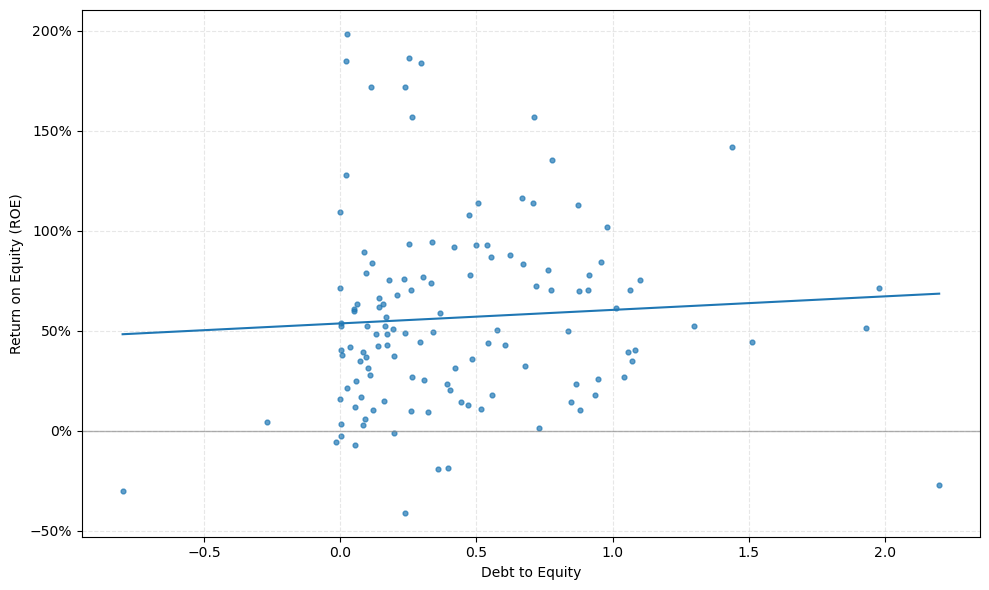

In [324]:
clean_dpdf = clean_dpdf[clean_dpdf['ROE'].between(-1,2)]
clean_dpdf = clean_dpdf[clean_dpdf['Debt to Equity'].between(-1, 5)]

# Scatterplot 
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the points
ax.scatter(clean_dpdf['Debt to Equity'], clean_dpdf['ROE'], s=12, alpha=0.7)

# Add a horzontal line at ROE = 0
ax.axhline(0, color='0.5', lw=1, alpha=0.6)

# Add a trend line (least squares)
if len(clean_dpdf) > 1:
    x = clean_dpdf['Debt to Equity'].to_numpy()
    y = clean_dpdf['ROE'].to_numpy()
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 100)
    ax.plot(xs, m*xs + b, lw=1.5, label='Trend line')
    
# Add labels
ax.set_xlabel('Debt to Equity')
ax.set_ylabel('Return on Equity (ROE)')
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend

# Add Pearson Correlation
corr_s = clean_dpdf['Debt to Equity'].corr(clean_dpdf['ROE'], method='spearman')
print(f"Spearman r = {corr_s:.2f}")
plt.tight_layout()
plt.show()

Companies with higher debt have higher Return on Equity (when they have positive profits), but the higher the debt a company holds and the lower the margins, the harder the hit from a loss

### 9g.2 - Profit Margin vs. Asset Turnover Chart DuPont Analysis Chart 2

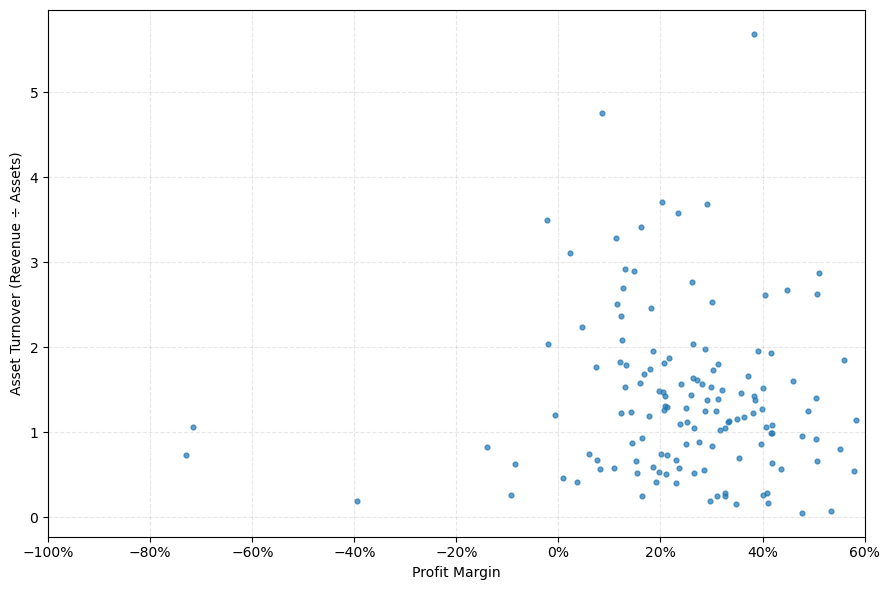

In [325]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Mask rows to margins in [-100%, +60%]
shrink_mask = dpdf['Profit Margin'].between(-1, 0.60)

# Plot arrays
profitm = dpdf.loc[shrink_mask, 'Profit Margin']
asset_t = dpdf.loc[shrink_mask, 'Asset_Turnover'].clip(
    lower=0,
    upper=np.percentile(dpdf['Asset_Turnover'].dropna(), 99)
)

plt.figure(figsize=(9, 6))
ax = plt.gca()
ax.scatter(profitm, asset_t, s=12, alpha=0.7)

ax.set_xlim(-1, 0.60)
ax.set_xlabel('Profit Margin')
ax.set_ylabel('Asset Turnover (Revenue ÷ Assets)')
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Print Results of 10 top ROE companies

In [326]:
top_ten = (dpdf).nlargest(10, 'ROE')[cols]

In [327]:
print(top_ten.sort_values('ROE', ascending =False))

     Business ID  Business State  Total Assets    Net Income  Asset_Turnover  \
88    9440752013      California       8102035  6.523305e+06        1.933009   
61    8527722013  South Carolina     295777000  1.300160e+08        1.563992   
116  11233162013     Connecticut      38273091  3.973851e+07        1.854580   
85    9284652013        Nebraska     106374899  4.637576e+08       11.384759   
56    8267732013    Pennsylvania     270548000  8.455700e+07        1.744360   
110  10930822013        Missouri     151500000  1.139000e+08        3.706271   
135  13789502013      California      69182000  7.413300e+07        3.682360   
118  11402152013      California      14749000  1.123900e+07        2.527697   
81    9236012013         Florida       9626665  8.067774e+06        3.577332   
11     422282013         Alabama      47756479  7.009672e+07        2.875939   

     Equity_Mult        ROE       ROA  
88     60.901530  49.034502  0.805144  
61     35.082078  15.421184  0.439574  

Print Results of 10 bottom  ROE companies

In [328]:
bottom_ten = dpdf.nsmallest(10, 'ROE')[cols]
print(bottom_ten.sort_values('ROE', ascending=False))

     Business ID Business State  Total Assets    Net Income  Asset_Turnover  \
123  12826482013          Texas    5356491000 -3.940820e+08        0.186597   
57    8343652013     Washington       3353342  4.010401e+06        2.668801   
60    8440592013        Florida     287093000 -7.883000e+07        0.096324   
87    9323722013     California      14357000  1.911600e+07        2.631608   
27    1056082013       Illinois      26714000 -2.022800e+07        1.056637   
18     934562013           Ohio     480877000  2.308320e+08        1.496813   
82    9241682013           Ohio      12808000 -6.871000e+06        0.735712   
42    7253632013       Virginia      10838572 -1.950442e+07        0.014724   
109  10919832013           Utah       2699519  1.300839e+07        6.577982   
142  14535932013        Montana      28877628  1.926341e+07        1.145295   

     Equity_Mult       ROE       ROA  
123     3.700231 -0.272229 -0.073571  
57     -0.252669 -0.302178  1.195942  
60      1.490

### Interpretation of Chart 2 

A higher ROE indicates that a company utilizes shareholder investments more effectively. The interpretation will vary based on industry, and after applying appropriate benchmarking comparisons. 

Overall, companies can adjust Return on Equity by increasing profit margin or asset turnover, or a combination of both.